In [1]:

import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
#import quandl
#import functools
import seaborn as sns
#import itertools
#from enum import Enum
import seaborn as sns
from datetime import date
from datetime import timedelta
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import cm


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
path = '/Users/hongyuli/Documents/UChi/Winter_2022/FINM33150 Regression & Quant Trading/hw4/For_Homework/'

In [3]:
#book_btc_usd = pd.read_csv(path+'book_narrow_BTC-USD_2021.delim',sep='\t')
#book_eth_btc = pd.read_csv(path+'book_narrow_ETH-BTC_2021.delim',sep='\t')
#book_eth_usd = pd.read_csv(path+'book_narrow_ETH-USD_2021.delim',sep='\t')
trades_btc_usd_df = pd.read_csv(path+'trades_narrow_BTC-USD_2021.delim',sep='\t')
trades_eth_btc_df = pd.read_csv(path+'trades_narrow_ETH-BTC_2021.delim',sep='\t')
trades_eth_usd_df = pd.read_csv(path+'trades_narrow_ETH-USD_2021.delim',sep='\t')

In [4]:
trades_btc_usd = trades_btc_usd_df.copy()#.set_index('timestamp_utc_nanoseconds')
trades_eth_btc = trades_eth_btc_df.copy()#.set_index('timestamp_utc_nanoseconds')
trades_eth_usd = trades_eth_usd_df.copy()#.set_index('timestamp_utc_nanoseconds')

In [5]:
#book_btc_usd.head()

In [6]:
trades_btc_usd.head(10)

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1618090136118837000,1618090132515484000,59120710000,9701240,-1.0
1,1618090136118594000,1618090132515484000,59125070000,8122450,-3.0
2,1618090136147838000,1618090132989553000,59119950000,6563880,-1.0
3,1618090136147583000,1618090132989553000,59125070000,614120,-1.0
4,1618090136153326000,1618090133074765000,59119950000,16995890,-1.0
5,1618090136185031000,1618090133470961000,59119960000,12790000,1.0
6,1618090136185285000,1618090133470961000,59122080000,3798090,1.0
7,1618090136194305000,1618090133557380000,59119960000,4517350,1.0
8,1618090136198771000,1618090133596148000,59119960000,2524570,1.0
9,1618090136201856000,1618090133613354000,59117620000,198200,-1.0


# Functions

In [7]:
def split_train(df,ratio):
    """split the dataframe into train and test datasets"""
    len_data = len(df.index)
    len_train = int(ratio*len_data)
    train_data = df.iloc[:len_train]
    test_data = df.iloc[len_train:]
    
    return train_data, test_data

In [8]:
def calc_return(df1,T):
 
    df_r = df1[['cum_log_return','timestamp_ns']]
    df_r = df_r.drop_duplicates(subset='timestamp_ns',keep='last')
    df_r = df_r.set_index('timestamp_ns')
    
    end_return = df_r.reindex(df_r.index + pd.Timedelta(str(T)+'s')).fillna(method='ffill')
    end_return.index = df_r.index
    r = end_return['cum_log_return']-df_r['cum_log_return']
    
    returns = pd.DataFrame({'return':r})
    returns.dropna(axis=0, inplace=True)
    
    return returns

In [9]:
def calc_flow(df1,tau):
#    df = df1.copy()
#    df = df.drop_duplicates(subset='timestamp_ns',keep='last')
#    df = df.set_index('timestamp_ns')
    
    df_f = df1[['cum_flow','timestamp_ns']]
    df_f = df_f.drop_duplicates(subset='timestamp_ns',keep='last')
    df_f = df_f.set_index('timestamp_ns')
    
    start_flow = df_f.reindex(df_f.index - pd.Timedelta(str(tau)+'s')).fillna(method='ffill')
    start_flow.index = df_f.index
    flow = df_f['cum_flow']-start_flow['cum_flow']
    
    
    returns = pd.DataFrame({'flow':flow})
    returns.dropna(axis=0, inplace=True)
    
    return returns

In [10]:
def reg(df_train,df_test):
    
    pred = df_train.copy()
    y = df_train['return']#.dropna()
    x = sm.add_constant(df_train['flow'])#.loc[y.index]
    reg = sm.OLS(y,x).fit()
    beta = reg.params[1]
    #alpha = reg.params[0]
    pred['r_hat'] = reg.predict()
    
    test = df_test.copy()
    test['r_hat'] = beta*test['flow']
    
    return pred, test, reg.summary()

In [11]:
def PnL_report(data):
    """exerpted from my homework in Portfolio Analysis course"""
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Mean'] = df.mean()
    report.loc['Vol'] = df.std() 
    report.loc['Sharpe'] = report.loc['Mean'] / report.loc['Vol']
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR'] = df.quantile(.05)
    report.loc['Expected Shortfall'] = df[df < df.quantile(.05)].mean()
    
    rolling_max = df.cummax()
    drawdown = df - rolling_max
    report.loc['Max Drawdown'] = drawdown.min()

    return round(report,4)

In [12]:
def calc_PnL(df1,tau,T,j,ratio):
    df1_c = df1.copy()
#    df2_c = df2.copy()
    
    flow_df = calc_flow(df1_c,tau)
    r_df = calc_return(df1_c,T)
    flow_df['return'] = r_df['return']
    
    
    df1_c.set_index('timestamp_ns',inplace=True)
    price_df = df1_c['price'].drop_duplicates(keep='last')
    flow_df = flow_df.join(price_df,how='inner')
    
    train_df_1, test_df_1 = split_train(flow_df,ratio)
    
    p_1,t_1,_ = reg(train_df_1,test_df_1)
    
    exp_d_return_1 = t_1['price']*t_1['return']
    t_1['exp_d_return'] = exp_d_return_1
    t_1['PnL'] = np.where(t_1['r_hat']>j,t_1['exp_d_return'],0) - np.where(t_1['r_hat']<-j,t_1['exp_d_return'],0)
    
    t_1['cum_PnL'] = t_1['PnL'].cumsum()
    
    return t_1['cum_PnL'][-1], PnL_report(t_1[['PnL']])

# Data Cleaning

In [13]:
trades = [trades_btc_usd,trades_eth_btc,trades_eth_usd]

In [14]:
for trade in trades:
    trade['price'] = trade['PriceMillionths']/1000000
    trade['side_sign'] = (trade['Side']>0)*1+(trade['Side']<0)*(-1)
    trade['cum_flow'] = trade['side_sign']*trade['SizeBillionths']
    trade['cum_flow'] = trade['cum_flow'].cumsum()
    trade['log_price'] = np.log(trade['price'])
    trade['log_return'] = trade['log_price'].diff()
    trade['cum_log_return'] = trade['log_return'].cumsum()
#    trade['PriceBillionths'] = trade['PriceMillionths']/1000
    trade['timestamp_ns'] = pd.to_datetime(trade['timestamp_utc_nanoseconds'],unit='ns')
#    trade.set_index('timestamp_ns',inplace=True)
    trade.drop(columns=['Side','received_utc_nanoseconds','PriceMillionths','timestamp_utc_nanoseconds','log_price','log_return'],inplace=True)

In [15]:
trades_btc_usd.head()

,SizeBillionths,price,side_sign,cum_flow,cum_log_return,timestamp_ns
0,9701240,59120.71,-1,-9701240,NaN,2021-04-10 21:28:52.515484
1,8122450,59125.07,-1,-17823690,0.000074,2021-04-10 21:28:52.515484
2,6563880,59119.95,-1,-24387570,-0.000013,2021-04-10 21:28:52.989553
3,614120,59125.07,-1,-25001690,0.000074,2021-04-10 21:28:52.989553
4,16995890,59119.95,-1,-41997580,-0.000013,2021-04-10 21:28:53.074765


# Try on the BTC USD data with tau=1s, T=2s

In [16]:
flow_data = calc_flow(trades_btc_usd,1)

In [17]:
r_data = calc_return(trades_btc_usd,2)

In [18]:
flow_data['return'] = r_data['return']
#flow_data['price'] = r_data['price']

In [19]:
flow_data

,flow,return
timestamp_ns,,
2021-04-13 16:10:31.608802,1.739766e+08,-0.013531
2021-04-13 16:10:31.638580,1.731222e+08,-0.013531
2021-04-13 16:10:31.797596,1.738751e+08,-0.013531
2021-04-13 16:10:32.722960,1.421947e+08,-0.013531
2021-04-13 16:10:32.979534,1.153847e+08,-0.013531
...,...,...
2021-04-27 00:22:15.081535,2.701576e+12,-0.035414
2021-04-27 00:22:16.402878,2.701455e+12,-0.035256
2021-04-27 00:22:16.428058,2.701457e+12,-0.035256


In [20]:
trades_btc_usd_df = trades_btc_usd.set_index('timestamp_ns')

In [21]:
trades_btc_usd_df.head()

,SizeBillionths,price,side_sign,cum_flow,cum_log_return
timestamp_ns,,,,,
2021-04-10 21:28:52.515484,9701240,59120.71,-1,-9701240,NaN
2021-04-10 21:28:52.515484,8122450,59125.07,-1,-17823690,0.000074
2021-04-10 21:28:52.989553,6563880,59119.95,-1,-24387570,-0.000013
2021-04-10 21:28:52.989553,614120,59125.07,-1,-25001690,0.000074
2021-04-10 21:28:53.074765,16995890,59119.95,-1,-41997580,-0.000013


In [22]:
price_data = trades_btc_usd_df['price'].drop_duplicates(keep='last')

In [23]:
price_data

timestamp_ns
2021-04-10 21:28:52.515484    59120.71
2021-04-10 21:28:52.989553    59125.07
2021-04-10 21:28:53.470961    59122.08
2021-04-10 21:28:55.577343    59123.81
2021-04-10 21:28:56.830404    59121.86
                                ...   
2021-04-27 00:22:15.081535    53745.89
2021-04-27 00:22:16.402878    53734.71
2021-04-27 00:22:16.428058    53737.42
2021-04-27 00:22:16.667433    53734.66
2021-04-27 00:22:17.851269    53731.07
Name: price, Length: 1141727, dtype: float64

In [24]:
flow_data = flow_data.join(price_data,how='inner')

In [25]:
flow_data

,flow,return,price
timestamp_ns,,,
2021-04-13 16:10:32.979534,1.153847e+08,-0.013531,63441.29
2021-04-13 16:11:45.367443,7.887908e+09,-0.013116,63414.98
2021-04-13 16:11:51.994195,7.545634e+09,-0.013098,63413.82
2021-04-13 16:12:08.364793,9.063145e+09,-0.013792,63457.89
2021-04-13 16:13:15.712803,1.369128e+10,-0.014079,63476.08
...,...,...,...
2021-04-27 00:22:15.081535,2.701576e+12,-0.035414,53745.89
2021-04-27 00:22:16.402878,2.701455e+12,-0.035256,53734.71
2021-04-27 00:22:16.428058,2.701457e+12,-0.035256,53737.42


In [26]:
#flow_data.head()

In [27]:
train_df, test_df = split_train(flow_data,.2)

In [28]:
p,t,summary = reg(train_df,test_df)

In [29]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                 2.066e+04
Date:                Sat, 12 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:46:05   Log-Likelihood:             6.1943e+05
No. Observations:              213563   AIC:                        -1.239e+06
Df Residuals:                  213561   BIC:                        -1.239e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027   3.65e-05     74.822      0.000       0.003       0.003
flow        -1.26e-14   8.77e-17   -143.721      0.000   -1.28e-14   -1.24e-14
==============================================================================
Omnibus:                   142376.522   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12114.081
Skew:                           0.002   Prob(JB):                         0.00
Kurtosis:                       1.833   Cond. No.                     5.26e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.26e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We have a negative beta with p-value of 0. This indicates that beta is statistically significant, and we should include it in our in-sample model. However, R-squared is only 8.8%, and we ought to include other factors into consideration when running the regression

In [30]:
p['residuals'] = p['return']-p['r_hat']

In [31]:
p

,flow,return,price,r_hat,residuals
timestamp_ns,,,,,
2021-04-13 16:10:32.979534,1.153847e+08,-0.013531,63441.29,0.002726,-0.016256
2021-04-13 16:11:45.367443,7.887908e+09,-0.013116,63414.98,0.002628,-0.015744
2021-04-13 16:11:51.994195,7.545634e+09,-0.013098,63413.82,0.002632,-0.015730
2021-04-13 16:12:08.364793,9.063145e+09,-0.013792,63457.89,0.002613,-0.016405
2021-04-13 16:13:15.712803,1.369128e+10,-0.014079,63476.08,0.002555,-0.016634
...,...,...,...,...,...
2021-04-17 01:00:17.650475,1.090418e+11,0.007815,61598.76,0.001353,0.006462
2021-04-17 01:00:17.881596,1.090378e+11,0.007861,61594.87,0.001353,0.006508
2021-04-17 01:00:17.881596,1.090378e+11,0.007861,61595.90,0.001353,0.006508


In [32]:
t['residuals'] = t['return']-t['r_hat']

In [33]:
t

,flow,return,price,r_hat,residuals
timestamp_ns,,,,,
2021-04-17 01:00:19.685756,1.090447e+11,0.007741,61603.27,-0.001374,0.009116
2021-04-17 01:00:19.928668,1.090106e+11,0.007742,61599.07,-0.001374,0.009116
2021-04-17 01:00:19.928668,1.090106e+11,0.007742,61603.21,-0.001374,0.009116
2021-04-17 01:00:19.933113,1.090108e+11,0.007742,61603.22,-0.001374,0.009116
2021-04-17 01:00:20.369901,1.090110e+11,0.007714,61604.97,-0.001374,0.009088
...,...,...,...,...,...
2021-04-27 00:22:15.081535,2.701576e+12,-0.035414,53745.89,-0.034052,-0.001362
2021-04-27 00:22:16.402878,2.701455e+12,-0.035256,53734.71,-0.034050,-0.001206
2021-04-27 00:22:16.428058,2.701457e+12,-0.035256,53737.42,-0.034050,-0.001206


[]

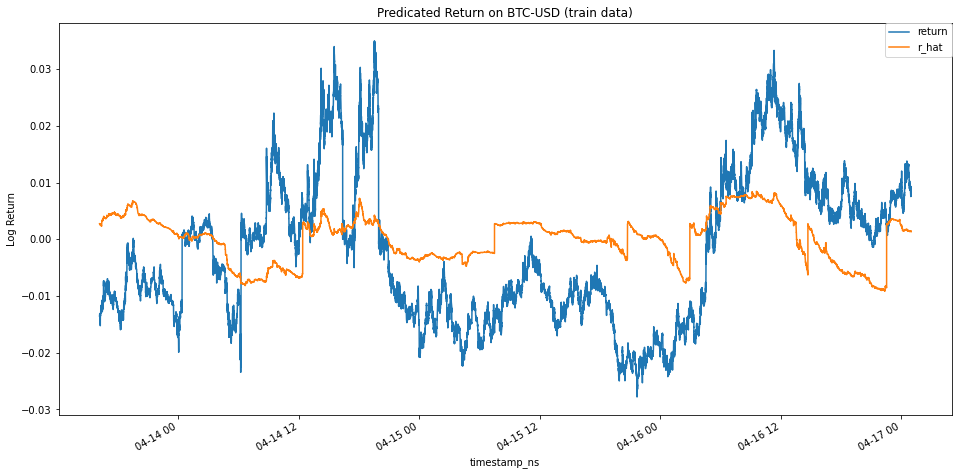

In [34]:
plt.figure()
train_r = p['return'].plot(figsize=(16,8))
train_r = p['r_hat'].plot()
train_r.set_title('Predicated Return on BTC-USD (train data)')
train_r.set_ylabel('Log Return')
plt.legend(loc="upper right", borderaxespad=0)
plt.plot()

The trend of in-sample data is generally consistent with the predicted values, but is less volatile compared to the true return

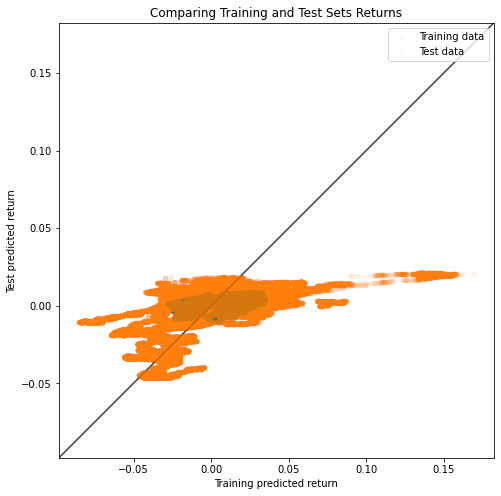

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(p['return'],p['r_hat'],s=20,alpha=0.025,label='Training data')
ax.scatter(t['return'],t['r_hat'],s=20,alpha=0.025,label='Test data')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_title('Comparing Training and Test Sets Returns')
ax.set_xlabel('Training predicted return')
ax.set_ylabel('Test predicted return')

plt.legend(loc="upper right")

### Analyzing residuals

#### Training Data

In [36]:
resid_p = p.loc[:,'residuals']
mu = resid_p.mean()
sigma = resid_p.std()
prob = np.linspace(0,1,len(resid_p.values))

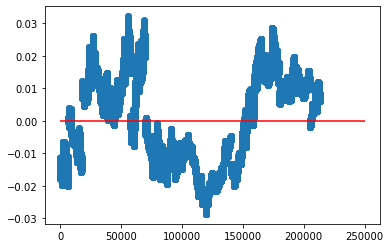

In [37]:
plt.figure()
plt.scatter(range(len(resid_p.values)),resid_p);
plt.hlines(y=0, xmin=0, xmax=250000, color='r')

More negative residuals at the center and more positive residuals at tails

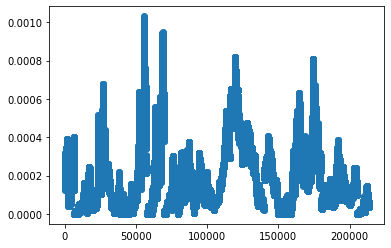

In [38]:
plt.scatter(range(len(resid_p.values)),resid_p**2);

The magnitude of the residuals does not show a clear patter as time goes by

In [39]:
resid_p.kurtosis()

-1.1667670348147203

The residual has negative kurtosis,which means that the distribution is flatter than a normal curve with the same mean and standard deviation

In [40]:
resid_p = resid_p.sort_values()

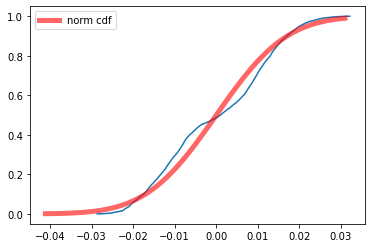

In [41]:
fig, ax = plt.subplots()
plt.step(resid_p,prob);
x = np.linspace(sigma*stats.norm.ppf(0.001),
                sigma * stats.norm.ppf(0.99), 100)
ax.plot(x, stats.norm.cdf((x-mu)/sigma),
      'r-', lw=5, alpha=0.6, label='norm cdf');
ax.legend();

In [42]:
#resid_p.kurtosis()

The pattern of the residuals is clearly not normal, and has less weight at the center compared to the close left and right around the center

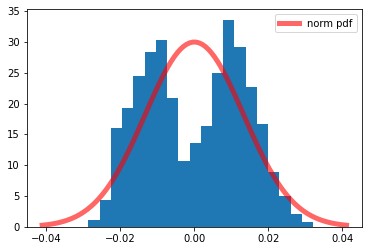

In [43]:
fig, ax = plt.subplots()
plt.hist(resid_p,bins=20,density=True);

x = np.linspace(sigma*stats.norm.ppf(0.001),
                sigma * stats.norm.ppf(0.999), 100)
ax.plot(x, stats.norm.pdf(x/sigma)/sigma,
      'r-', lw=5, alpha=0.6, label='norm pdf');
ax.legend();

The comparsion with normal pdf is clearer, showing we rarely make the exactly correct predictions on the return. We do make some negative as well as some positive excess returns compared to our predictions. 

In [44]:
(resid_p>0).sum()/((resid_p>0).sum()+(resid_p<=0).sum())

0.513661074249753

About 51.37% of the times, we make higher returns compared to our predictions, which is consistent with the training data

#### Test Data

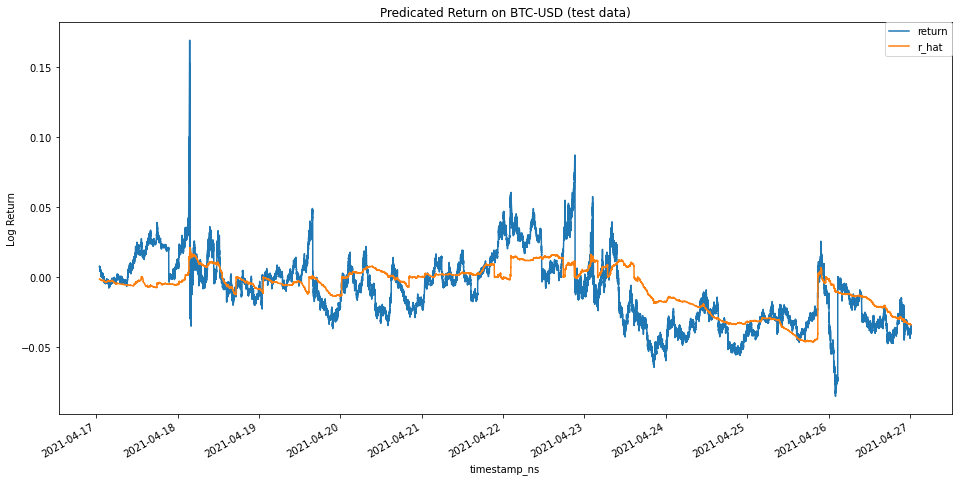

In [45]:
plt.figure()
r = t['return'].plot(figsize=(16,8))
r = t['r_hat'].plot()
r.set_title('Predicated Return on BTC-USD (test data)')
r.set_ylabel('Log Return')
plt.legend(loc="upper right", borderaxespad=0)
plt.show()

In [46]:
resid_t = t.loc[:,'residuals']
mu = resid_t.mean()
sigma = resid_t.std()
prob = np.linspace(0,1,len(resid_t.values))

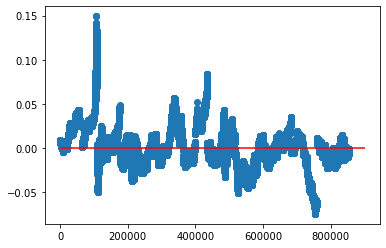

In [47]:
plt.figure()
plt.scatter(range(len(resid_t.values)),resid_t);
plt.hlines(y=0, xmin=0, xmax=900000, color='r')

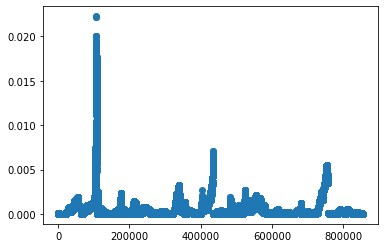

In [48]:
plt.scatter(range(len(resid_t.values)),resid_t**2);

Higher residuals in absolute terms at the left tail. And much higher values of the residuals compared with the training data set

In [49]:
resid_t = resid_t.sort_values()

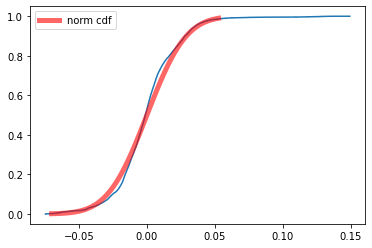

In [50]:
fig, ax = plt.subplots()
plt.step(resid_t,prob);
x = np.linspace(sigma*stats.norm.ppf(0.001),
                sigma * stats.norm.ppf(0.99), 100)
ax.plot(x, stats.norm.cdf((x-mu)/sigma),
      'r-', lw=5, alpha=0.6, label='norm cdf');
ax.legend();

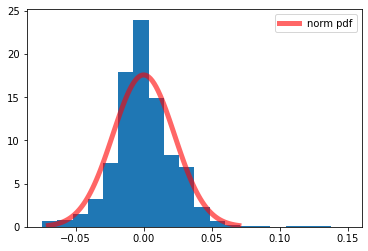

In [51]:
fig, ax = plt.subplots()
plt.hist(resid_t,bins=20,density=True);

x = np.linspace(sigma*stats.norm.ppf(0.001),
                sigma * stats.norm.ppf(0.999), 100)
ax.plot(x, stats.norm.pdf(x/sigma)/sigma,
      'r-', lw=5, alpha=0.6, label='norm pdf');
ax.legend();

In [52]:
(resid_t>0).sum()/((resid_t>0).sum()+(resid_t<=0).sum())

0.4717923804952854

There are fewer cases where we have positive excess returns relative to our predictions (47.18%)

In [53]:
resid_t.sum()

21.428261838728872

However, the magnitude of the residuals are much higher compared to the negative ones, resulting in a positive cumulative PnL in general

The residuals on the test dataset is closer to normal compared with the training dataset, but has more extreme positive values.

### Try j=1%

Trade if r_hat > j or r_hat <-j

In [54]:
j = 0.01
greater_j = t[t['r_hat']>j]
smaller_neg_j = t[t['r_hat']<-j]

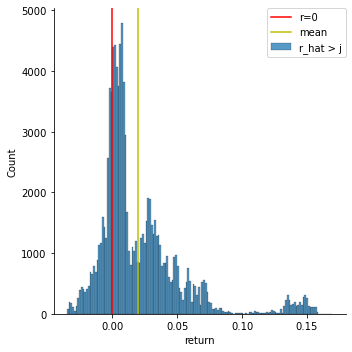

In [55]:
sns.displot(greater_j['return'],label='r_hat > j')
plt.axvline(0, c='r',label='r=0')
plt.axvline(greater_j['return'].mean(), c='y',label='mean')
plt.legend(loc="upper right", borderaxespad=0)

For the case where r_hat>j, the mean of the return is positive, which implies that the direction of our strategy is generally correct in this case

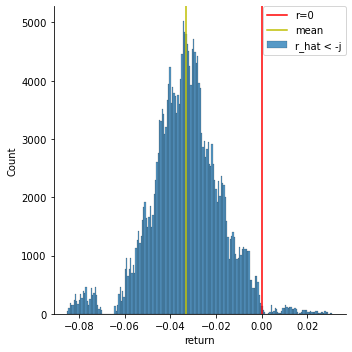

In [56]:
sns.displot(smaller_neg_j['return'],label='r_hat < -j')
plt.axvline(0, c='r',label='r=0')
plt.axvline(smaller_neg_j['return'].mean(), c='y',label='mean')
plt.legend(loc="upper right", borderaxespad=0)

For the case where r_hat<-j, the mean of the return is negative, which implies that the direction of our strategy is generally correct in this case. The magnitude of the negative mean is much larger than the positive mean. In this case, our profits comes more from shorting the negative parts

### OOS PnL

#### Out-of-Sample PnL

In [57]:
exp_d_return = t['price']*t['return']

In [58]:
t = t.drop_duplicates(keep='last')

In [59]:
t['exp_d_return'] = exp_d_return#[t['r_hat']>j] - PnL[t['r_hat']<-j]

t['PnL'] = np.where(t['r_hat']>j,t['exp_d_return'],0) - np.where(t['r_hat']<-j,t['exp_d_return'],0)

In [60]:
t['cum_PnL'] = t['PnL'].cumsum()

In [61]:
t

,flow,return,price,r_hat,residuals,exp_d_return,PnL,cum_PnL
timestamp_ns,,,,,,,,
2021-04-17 01:00:19.685756,1.090447e+11,0.007741,61603.27,-0.001374,0.009116,476.889356,0.000000,0.000000e+00
2021-04-17 01:00:19.928668,1.090106e+11,0.007742,61599.07,-0.001374,0.009116,476.916838,0.000000,0.000000e+00
2021-04-17 01:00:19.928668,1.090106e+11,0.007742,61603.21,-0.001374,0.009116,476.948891,0.000000,0.000000e+00
2021-04-17 01:00:19.933113,1.090108e+11,0.007742,61603.22,-0.001374,0.009116,476.938969,0.000000,0.000000e+00
2021-04-17 01:00:20.369901,1.090110e+11,0.007714,61604.97,-0.001374,0.009088,475.202493,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...
2021-04-27 00:22:15.081535,2.701576e+12,-0.035414,53745.89,-0.034052,-0.001362,-1903.348081,1903.348081,5.375402e+08
2021-04-27 00:22:16.402878,2.701455e+12,-0.035256,53734.71,-0.034050,-0.001206,-1894.483249,1894.483249,5.375421e+08
2021-04-27 00:22:16.428058,2.701457e+12,-0.035256,53737.42,-0.034050,-0.001206,-1894.578793,1894.578793,5.375440e+08


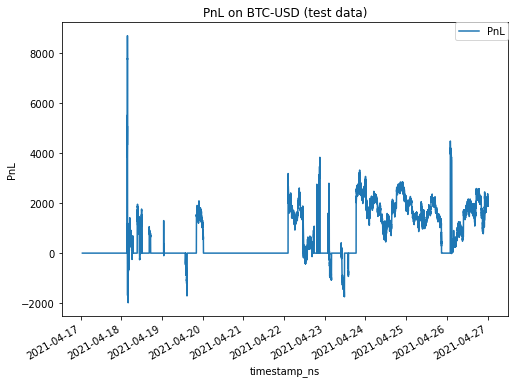

In [62]:
plt.figure(figsize=(8,6))
cum_pnl = t['PnL'].plot()
cum_pnl.set_title('PnL on BTC-USD (test data)')
cum_pnl.set_ylabel('PnL')
plt.legend(loc="upper right", borderaxespad=0)

We are making the largest amount of money when the market is volatile. From the graph, there quite a few high gains and only some small losses

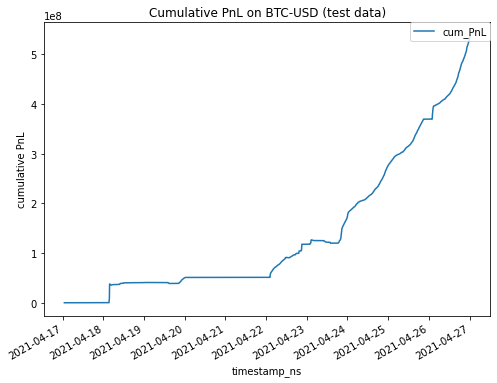

In [63]:
plt.figure(figsize=(8,6))
cum_pnl = t['cum_PnL'].plot()
cum_pnl.set_title('Cumulative PnL on BTC-USD (test data)')
cum_pnl.set_ylabel('cumulative PnL')
plt.legend(loc="upper right", borderaxespad=0)

The cumulative PnL is increasing most significantly when we are trading most frequently (corresponding slope steeper)

### Important Meansures and Ratios

In [64]:
report_test = PnL_report(t[['PnL']])

In [65]:
report_test

,PnL
Mean,629.2592
Vol,1070.8126
Sharpe,0.5876
Skewness,2.1081
Excess Kurtosis,7.3302
VaR,0.0000
Expected Shortfall,-464.4495
Max Drawdown,-10683.4291


The strategy has a Sharpe ratio of 0.5876. Although our main PnL is large, our volatility is about 2 times larger than the mean, which indicates that the training set may not be that useful in predicting future returns. Kurtosis is about 7.33, and thus the PnL has much fatter tails than a normal distribution. Max drawdown is about 10,000, which is not as large compared to our profits

### Different Training and Test Periods

In [66]:
cum_PnL_df_2 = pd.DataFrame(columns=['cum_PnL'])

for i in range(10,100,10):
    l = len(cum_PnL_df_2.index)
#             cum_PnL_df.loc[l,'tau'] = tau_i
#             cum_PnL_df.loc[l,'T'] = T_i
#             cum_PnL_df.loc[l,'j'] = j_i
    cum_PnL_2, rpt_2 = calc_PnL(trades_btc_usd,1,2,0.01,i/100)
    cum_PnL_df_2.loc[l,'cum_PnL'] = cum_PnL_2
    cum_PnL_df_2.loc[l,'Sharpe Ratio'] = rpt_2.loc['Sharpe','PnL']
    print(str(i)+'% of training data and '+str(100-i)+'% of test data')
    display(rpt_2.T)

10% of training data and 90% of test data


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,514.0199,970.1153,0.5299,2.4779,10.4772,0.0,-416.9835,-10683.4291


20% of training data and 80% of test data


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,629.2592,1070.8126,0.5876,2.1081,7.3302,0.0,-464.4495,-10683.4291


30% of training data and 70% of test data


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,874.6744,1145.2199,0.7638,1.2598,3.5018,-183.844,-733.8831,-10858.1868


40% of training data and 60% of test data


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,908.9314,1083.2603,0.8391,0.6338,-0.3701,-4.3002,-610.0917,-5992.4836


50% of training data and 50% of test data


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,1032.5163,1101.4391,0.9374,0.4364,-0.5739,-40.9265,-607.1635,-5992.4836


60% of training data and 40% of test data


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,1065.969,1124.568,0.9479,0.3955,-0.5425,0.0,-755.4701,-5992.4836


70% of training data and 30% of test data


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,1317.7461,1045.4868,1.2604,0.1496,-0.4549,0.0,-859.8053,-4501.4846


80% of training data and 20% of test data


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,1204.1658,1059.775,1.1362,0.6224,0.0105,0.0,-6.3851,-4501.4846


90% of training data and 10% of test data


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,1651.7012,958.124,1.7239,0.7192,0.7183,224.1575,70.3446,-4501.4846


In [67]:
cum_PnL_df_2.sort_values(by='Sharpe Ratio',ascending=False)

,cum_PnL,Sharpe Ratio
8,176371952.738088,1.7239
6,422134706.993434,1.2604
7,257166462.988035,1.1362
5,455305207.435952,0.9479
4,551269756.302299,0.9374
3,582344169.898883,0.8391
2,653795533.23922,0.7638
1,537547809.330974,0.5876
0,493992131.975521,0.5299


With more training data, max drawdown decreases; the Sharpe Ratio is higher, but it might indicate the problem of over-fitting

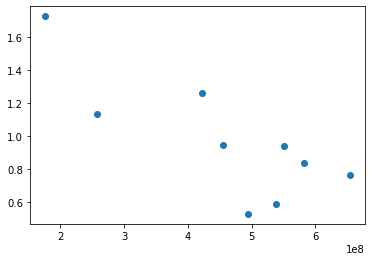

In [68]:
plt.scatter(cum_PnL_df_2['cum_PnL'],cum_PnL_df_2['Sharpe Ratio'])

There is no clear relationship between Sharpe ratio and cum_PnL when the training dataset is different

# Try different combinations of tau, T, and j

In [69]:
tau_list = [0.5,1,2,5,10]
T_list = [0.5,1,2,5,10]
j_list = [0.005,0.01,0.02]

## BTC-USD

In [70]:
cum_PnL_df = pd.DataFrame(columns=['tau','T','j','cum_PnL'])

for tau_i in tau_list:
    for T_i in T_list:
        for j_i in j_list:
            l = len(cum_PnL_df.index)
            cum_PnL_df.loc[l,'tau'] = tau_i
            cum_PnL_df.loc[l,'T'] = T_i
            cum_PnL_df.loc[l,'j'] = j_i
            cum_PnL, rpt = calc_PnL(trades_btc_usd,tau_i,T_i,j_i,.2)
            cum_PnL_df.loc[l,'cum_PnL'] = cum_PnL
            cum_PnL_df.loc[l,'Sharpe Ratio'] = rpt.loc['Sharpe','PnL']
            if rpt.loc['Sharpe','PnL'] > 0.5:
                print('tau={},T={},j={}'.format(tau_i,T_i,j_i))
                display(rpt.T)

tau=0.5,T=0.5,j=0.005


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,941.1197,1451.5533,0.6484,1.0342,0.8964,-1040.8418,-1431.0307,-6822.1435


tau=0.5,T=0.5,j=0.01


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,887.0476,1447.2698,0.6129,1.1556,1.0658,-993.7975,-1404.3068,-6815.612


tau=0.5,T=0.5,j=0.02


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,773.2291,1419.3071,0.5448,1.4335,1.7021,-706.6004,-1347.1389,-5654.6734


tau=1,T=0.5,j=0.005


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,849.826,1521.2327,0.5586,0.9649,0.718,-1199.6193,-1580.8974,-7497.7831


tau=1,T=0.5,j=0.01


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,852.9321,1464.0289,0.5826,1.2094,1.0783,-913.0765,-1300.7438,-7497.7831


tau=1,T=0.5,j=0.02


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,784.5377,1437.146,0.5459,1.4744,1.549,-516.5429,-1095.7303,-7497.7831


tau=1,T=2,j=0.005


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,761.5249,1188.885,0.6405,1.3207,3.9621,-528.1207,-1140.4611,-10858.1868


tau=1,T=2,j=0.01


,Mean,Vol,Sharpe,Skewness,Excess Kurtosis,VaR,Expected Shortfall,Max Drawdown
PnL,629.2592,1070.8126,0.5876,2.1081,7.3302,0.0,-464.4495,-10683.4291


In [71]:
cum_PnL_df_1 = cum_PnL_df.dropna(axis=0)

In [72]:
(cum_PnL_df_1['cum_PnL']>0).sum()

29

In [73]:
(cum_PnL_df_1['cum_PnL']<0).sum()

7

The strategy generates about 4 more times of positive cumulative PnL compared to negative ones

In [74]:
cum_PnL_df_1.sort_values(by='Sharpe Ratio',ascending=False, inplace=True)

In [75]:
cum_PnL_df_1

,tau,T,j,cum_PnL,Sharpe Ratio
0,0.5,0.5,0.005,820645105.446565,0.6484
21,1,2,0.005,650536484.001608,0.6405
1,0.5,0.5,0.01,773494856.187589,0.6129
22,1,2,0.01,537547809.330974,0.5876
16,1,0.5,0.01,728621483.836726,0.5826
15,1,0.5,0.005,725968080.202169,0.5586
17,1,0.5,0.02,670195240.734492,0.5459
2,0.5,0.5,0.02,674246529.645562,0.5448
18,1,1,0.005,799909739.042218,0.4852
19,1,1,0.01,774847743.336241,0.4823


The highest Sharpe Ratio is about 0.6484, which implies that the return is not that promising compared to its volatilities. When tau and T are closer to each other, the cumulative PnL is generally larger than larger differences

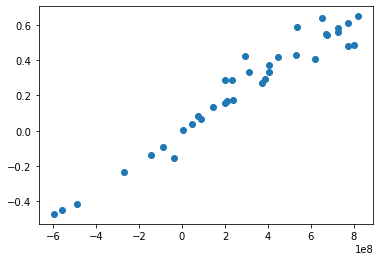

In [76]:
plt.scatter(cum_PnL_df_1['cum_PnL'],cum_PnL_df_1['Sharpe Ratio'])

Fixing the training dataset, cum_PnL increases as Sharpe Ratio increases